# Useful Applications

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt
import math

import statsmodels.api as sm
from statsmodels import regression

from jupyterthemes import jtplot
jtplot.style(theme='onedork', figsize=(15, 9))

## Class

In [3]:
class UsefulApplications():
    def __init__(self, ticker, start, end):
        self.ticker = ticker
        self.start = start
        self.end = end
        self.get_data()
    
    def get_data(self):
        data = yf.download(self.ticker, self.start, self.end, interval='1d', auto_adjust=False, progress=False)
        data['returns'] = np.log(data['Close'].div(data['Close'].shift(1)))
        data.dropna(inplace=True)
        self.asset = data
        return data
        
    def amihud_illiquidity(self):        
        data = self.asset.copy()
        
        dollar_vol = data['Volume'] * data['Close']
        rtrns = np.abs(np.log(data['Close'].div(data['Close'].shift(1))))
        illiq = rtrns[1:] / (dollar_vol[1:])
        
        self.print_msg(f'Aminud\'s illiquidity  for {self.ticker} is {illiq.mean()}')
    
    def rolls_spread(self):
        data = self.asset.copy()
        
        data['Diff'] = data['Close'].diff()
        data_cov     = np.cov(data['Diff'][1:-1], data['Diff'][2:])
        
        if data_cov[0, 1] < 0:
            self.print_msg(f'Roll\'s Spread for {self.ticker}: {round(2*np.sqrt(-data_cov[0,1]), 5)}')
        else:
            self.print_msg(f'Roll\'s Spread for {self.ticker}: {round(2*np.sqrt(data_cov[0,1]), 5)}')
    
    def pastor_stambaugh_liquidity():
        pass
    
    def print_msg(self, msg):
        print(len(msg)*'*')
        print(msg)
#         print(len(msg)*'*')
    
    def summary(self):
        self.rolls_spread()
        self.amihud_illiquidity()
    


In [5]:
u_app = UsefulApplications('IBM', dt.datetime(2013, 10, 1), dt.datetime(2013, 10, 30))
u_app.rolls_spread()
u_app.amihud_illiquidity()

******************************
Roll's Spread for IBM: 1.01175
*******************************************************
Aminud's illiquidity  for IBM is 1.1600426194329588e-11


In [ ]:
def rolls_spread(ticker, start=dt.datetime(2002, 1, 1), end=dt.datetime(2022, 12, 31), interval='1d', adjustment=False):
    asset               = yf.download(ticker, start, end, interval, auto_adjust=adjustment, progress=False)
    asset_close         = asset['Close'].to_frame()
    asset_close['Diff'] = asset_close['Close'].diff()
    asset_close_cov     = np.cov(asset_close['Diff'][1:-1], asset_close['Diff'][2:])

    if asset_close_cov[0, 1] < 0:
        print(f'Roll\'s Spread for {ticker}: {round(2*np.sqrt(-asset_close_cov[0,1]), 3)}')
    else:
        print(f'Roll\'s Spread for {ticker}: {round(2*np.sqrt(asset_close_cov[0,1]), 3)}')

## Roll's model to estimate spread (1984)

- __[Trading costs - The Roll Spread Estimator](https://ba-odegaard.no/teach/notes/liquidity_estimators/roll_spread_estimator/roll_lectures.pdf)__
- __[A Simple Implicit Measure of the Effective Bid-Ask Spread in an Efficient Market](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1540-6261.1984.tb03897.x)__

In [22]:
rolls_spread('AAPL', adjustment=True)

Roll's Spread for AAPL: 0.512


### Research

In [2]:
df = pd.read_csv('../../data/IBM_2013-09-01_2013-11-11_1d.csv', index_col=0, parse_dates=True)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2013-09-03,117.398367,117.839496,116.682332,117.609344,3647611,0.0,0.0
2013-09-04,117.366468,117.756444,116.554525,117.078766,2717403,0.0,0.0
2013-09-05,117.219388,118.274267,117.040379,117.730843,2999510,0.0,0.0
2013-09-06,118.050496,118.267872,116.771854,117.014801,3037061,0.0,0.0
2013-09-09,117.430359,118.587533,117.193810,118.261475,3155991,0.0,0.0


In [3]:
close = df['Close'].to_frame()
close.head()

,Close
Date,
2013-09-03,117.609344
2013-09-04,117.078766
2013-09-05,117.730843
2013-09-06,117.014801
2013-09-09,118.261475


In [4]:
close['Diff'] = df['Close'].diff()
close.head()

,Close,Diff
Date,,
2013-09-03,117.609344,NaN
2013-09-04,117.078766,-0.530579
2013-09-05,117.730843,0.652077
2013-09-06,117.014801,-0.716042
2013-09-09,118.261475,1.246674


In [5]:
_cov = np.cov(close['Diff'][1:-1], close['Diff'][2:])
_cov[0, 1]

-0.14103707800980902

In [6]:
np.corrcoef(close['Diff'][1:-1], close['Diff'][2:])[0,1]

-0.05134942727349844

In [7]:
if _cov[0, 1] < 0:
    print(f'Roll\'s Spread for IBM: {round(2*np.sqrt(-_cov[0,1]), 3)}')
else:
    print(f'Roll\'s Spread for IBM: {round(2*np.sqrt(_cov[0,1]), 3)}')

Roll's Spread for IBM: 0.751


In [8]:
ibm_wo_adjustment = yf.download('IBM', dt.datetime(2013, 9, 11), dt.datetime(2013, 11, 11), '1d')

[*********************100%***********************]  1 of 1 completed


In [10]:
ibm_wo_adj_close = ibm_wo_adjustment['Close'].to_frame()
ibm_wo_adj_close['Diff'] = ibm_wo_adj_close['Close'].diff()
ibm_wo_adj_close.head()

,Close,Diff
Date,,
2013-09-11,182.313583,NaN
2013-09-12,182.342255,0.028671
2013-09-13,183.718933,1.376678
2013-09-16,184.655838,0.936905
2013-09-17,183.709366,-0.946472


In [12]:
_ibm_wo_adj_cov = np.cov(ibm_wo_adj_close['Diff'][1:-1], ibm_wo_adj_close['Diff'][2:])
_ibm_wo_adj_cov[0, 1]

-0.5197988161154193

In [13]:
if _ibm_wo_adj_cov[0, 1] < 0:
    print(f'Roll\'s Spread for IBM(no adjustment): {round(2*np.sqrt(-_ibm_wo_adj_cov[0,1]), 3)}')
else:
    print(f'Roll\'s Spread for IBM(no adjustment): {round(2*np.sqrt(_ibm_wo_adj_cov[0,1]), 3)}')

Roll's Spread for IBM(no adjustment): 1.442


## Amihud's model for illiquidity (2002)

- __[Amihud Illiquidity Measure](https://breakingdownfinance.com/finance-topics/alternative-investments/amihud-illiquidity-measure/)__
- __[ILLIQUIDITY AND STOCK RETURNS: Cross-Section and Time-Series Effects](https://deliverypdf.ssrn.com/delivery.php?ID=996103073088116024117083087064091068036022029078044001090016109113126101021095072012074014095026118068068048028116102114123091093097081107024117113108069091098068086072104076008064076097125&EXT=pdf&INDEX=TRUE)__
- __[The Night and Day of Amihud’s (2002) Liquidity Measure](https://www.chapman.edu/business/_files/faculty-research/2019-conference-money-finance/yashar-barardehi-paper.pdf)__
- __[Price Impact or Trading Volume: Why is the Amihud (2002) Illiquidity Measure Priced?](https://www.lehigh.edu/~jms408/Lu_2014.pdf)__
- __[Illiquidity: A study on how investing in illiquid assets can be profitable](http://arno.uvt.nl/show.cgi?fid=142126)__
- __[An Analysis of the Amihud Illiquidity Premium](https://www.researchgate.net/publication/228315879_An_Analysis_of_the_Amihud_Illiquidity_Premium)__
- __[Illiquidity and Stock Returns: Empirical Evidence from the Stockholm Stock Exchange](http://arc.hhs.se/download.aspx?MediumId=1481)__

In [3]:
ibm_df = yf.download('IBM', dt.datetime(2013, 10, 1), dt.datetime(2013, 10, 30), '1d', auto_adjust=True)
ibm_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2013-10-01,118.491670,119.329174,118.050531,119.156563,2804535,0.0,0.0
2013-10-02,118.619521,119.111803,117.897088,118.248718,3783487,0.0,0.0
2013-10-03,118.082467,118.248690,116.995619,117.545441,3359543,0.0,0.0
2013-10-04,117.743620,118.357370,117.366429,117.698875,2995326,0.0,0.0
2013-10-07,116.260399,117.193809,116.260399,116.362694,4148854,0.0,0.0
2013-10-08,116.285990,116.349928,114.252956,114.259354,5834902,0.0,0.0
2013-10-09,114.674874,116.145310,114.502253,115.921547,4626981,0.0,0.0
2013-10-10,117.104308,118.127228,116.586465,118.127228,3827209,0.0,0.0
2013-10-11,118.434088,119.060614,117.711656,119.015869,3381300,0.0,0.0


In [44]:
close      = np.array(ibm_df['Close'])
dollar_vol = np.array(ibm_df['Volume'] * close)
returns    = np.array((close[1:] - close[:-1]) / close[1:])
illiq      = np.mean(np.divide(np.abs(returns), dollar_vol[1:]))
print(f'Aminud\'s illiquidity is {illiq}')

Aminud's illiquidity is 1.7348991460001093e-11


In [48]:
close_pd      = ibm_df['Close']
dollar_vol_pd = ibm_df['Volume'] * close_pd
rtrns         = np.abs(np.log(close_pd.div(close_pd.shift(1))))
illiq_pd      = rtrns[1:] / (dollar_vol_pd[1:])
print(f'Aminud\'s illiquidity is {illiq_pd.mean()}')

Aminud's illiquidity is 1.7334306291309935e-11


## Pastor and Stambaugh (2003) liquidity measure

- __[Pastor Stambaugh Model](https://breakingdownfinance.com/finance-topics/equity-valuation/pastor-stambaugh-model/)__
- __[Liquidity Risks and Expected Stock Resturns](https://pages.stern.nyu.edu/~lpederse/courses/LAP/papers/TransactionCosts/PastorStam.pdf)__
- __[Liquidity Risk After 20 Years](https://bfi.uchicago.edu/wp-content/uploads/BFI_WP_201957.pdf)__
- __[Liquidity Risk?](https://cfr.pub/published/papers/pontiff2020liquidity.pdf)__

In [24]:
ibm_df  = yf.download('IBM', dt.datetime(2013, 1, 1), dt.datetime(2013, 11, 19), '1d', auto_adjust=True)

spy_df  = yf.download('SPY', dt.datetime(2013, 1, 1), dt.datetime(2013, 11, 19), '1d', auto_adjust=True)
gspc_df = yf.download('^GSPC', dt.datetime(2013, 1, 1), dt.datetime(2013, 11, 19), '1d', auto_adjust=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [25]:
ibm_rtrns  = np.log(ibm_df['Close'].div(ibm_df['Close'].shift(1)))
spy_rtrns  = np.log(spy_df['Close'].div(spy_df['Close'].shift(1)))
gspc_rtrns = np.log(gspc_df['Close'].div(gspc_df['Close'].shift(1)))

In [26]:
ibm_dollar_volume = ibm_df['Volume'] * ibm_df['Close']

In [39]:
x_2t = np.sign(ibm_rtrns - spy_rtrns) * ibm_dollar_volume
x_2t.dropna(inplace=True)

In [29]:
ibm_dollar_volume.name = 'Volume'

In [30]:
returns_volume = pd.merge(ibm_rtrns, ibm_dollar_volume, left_index=True, right_index=True)
returns_volume.dropna(inplace=True)

In [31]:
returns_volume

,Close,Volume
Date,,
2013-01-03,-0.005515,4.693826e+08
2013-01-04,-0.006577,4.324653e+08
2013-01-07,-0.004391,3.646003e+08
2013-01-08,-0.001399,3.850279e+08
2013-01-09,-0.002855,4.074080e+08
...,...,...
2013-11-12,0.001039,5.241434e+08
2013-11-13,0.002619,5.805438e+08
2013-11-14,-0.007328,7.744056e+08


In [32]:
returns_volume.rename(columns={'Close': 'ibm_returns'}, inplace=True)
returns_volume

,ibm_returns,Volume
Date,,
2013-01-03,-0.005515,4.693826e+08
2013-01-04,-0.006577,4.324653e+08
2013-01-07,-0.004391,3.646003e+08
2013-01-08,-0.001399,3.850279e+08
2013-01-09,-0.002855,4.074080e+08
...,...,...
2013-11-12,0.001039,5.241434e+08
2013-11-13,0.002619,5.805438e+08
2013-11-14,-0.007328,7.744056e+08


In [37]:
x_1t = spy_rtrns.copy()
x_1t.dropna(inplace=True)

In [38]:
x_1t

Date
2013-01-03   -0.002261
2013-01-04    0.004382
2013-01-07   -0.002736
2013-01-08   -0.002882
2013-01-09    0.002539
                ...   
2013-11-12   -0.002032
2013-11-13    0.007992
2013-11-14    0.004977
2013-11-15    0.004342
2013-11-18   -0.003505
Name: Close, Length: 222, dtype: float64

In [40]:
x_2t

Date
2013-01-03   -4.693826e+08
2013-01-04   -4.324653e+08
2013-01-07   -3.646003e+08
2013-01-08    3.850279e+08
2013-01-09   -4.074080e+08
                  ...     
2013-11-12    5.241434e+08
2013-11-13   -5.805438e+08
2013-11-14   -7.744056e+08
2013-11-15    6.375009e+08
2013-11-18    6.628902e+08
Length: 222, dtype: float64

In [46]:
benchmark = sm.add_constant(x_1t)
model = regression.linear_model.OLS(x_2t, benchmark).fit()
alpha = model.params[0]
beta = model.params[1]

bm2 = np.linspace(benchmark.min(), benchmark.max(), 100)
a_hat = bm2 * beta + alpha
# plt.scatter(benchmark, x_2t, alpha=0.3)
# plt.plot(bm2, a_hat, 'r')
# plt.xlabel('BENCHMARK value')
# plt.ylabel('ASSET value')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.981
Date:                Wed, 28 Jun 2023   Prob (F-statistic):             0.0857
Time:                        21:59:35   Log-Likelihood:                -4802.4
No. Observations:                 222   AIC:                             9609.
Df Residuals:                     220   BIC:                             9616.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.254e+07   4.09e+07     -0.796      0.427   -1.13e+08    4.81e+07
Close      -1.003e+10   5.81e+09     -1.727      0.086   -2.15e+10    1.42e+09
==============================================================================
Omnibus:                       11.586   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               13.674
Skew:                          -0.425   Prob(JB):                      0.00107
Kurtosis:                       3.869   Cond. No.                         143.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

f:\python\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Constant: -32535134.690188758
MLR beta to S&P 500: -10030982109.166832


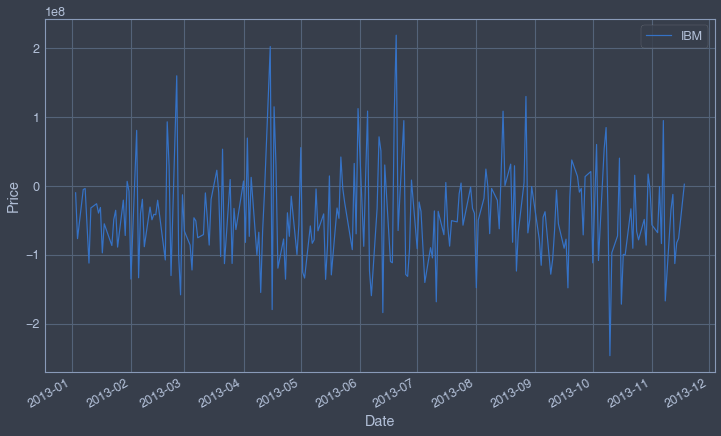

In [59]:
benchmark = sm.add_constant(x_1t)
mlr = regression.linear_model.OLS(x_2t, benchmark).fit()
prediction = mlr.params[0] + mlr.params[1] * x_1t

print(f'Constant: {mlr.params[0]}')
print(f'MLR beta to S&P 500: {mlr.params[1]}')

# ibm_rtrns.plot()
prediction.plot();
plt.ylabel('Price')
plt.legend(['IBM', 'Linear Regression Prediction']);

<AxesSubplot:xlabel='Date'>

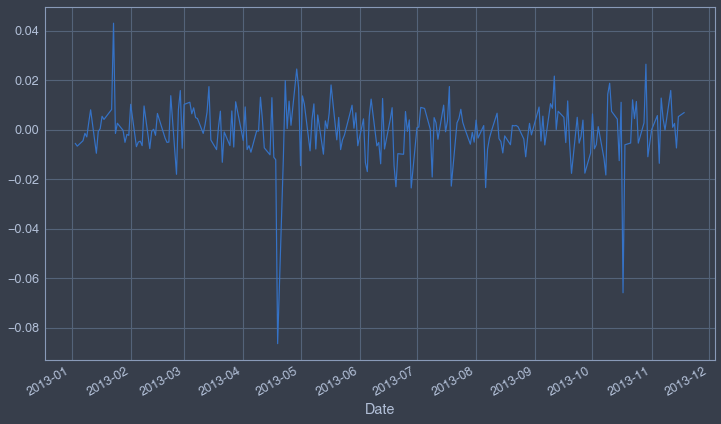

In [58]:
ibm_rtrns.plot()